In [13]:
import utils.data as data
import utils.dashboard as dashboard

import matplotlib.pyplot as plt
import numpy as np

import base64
from io import BytesIO

import boto3

In [5]:
df = data.preprocessing()

In [6]:

def get_philly_data(streams):
    """
    """
    latlon_data = {"xs": [], "ys": []}

    for key, obj in streams.items():
        if 'latlng' in obj:
            y, x = np.transpose(obj['latlng']['data'])
            if np.mean(x) > -75.4 and np.mean(x) < -75 and np.mean(y) > 39.6:
                latlon_data['xs'].append(x)
                latlon_data['ys'].append(-1 * y)
    return latlon_data


def latlon_to_imshow(latlon_data):
    """
    """
    hist, _, _ = np.histogram2d(
        np.hstack(latlon_data['ys']),
        np.hstack(latlon_data['xs']),
        bins=125)

    return np.log(hist + .01)



bucket_name = "strava-raw"
streams = data.load_table(bucket_name, "streams.json")
latlon = get_philly_data(streams)
img_data = latlon_to_imshow(latlon)

Text(0.05, 0, 'Updated daily at 11:30pm EST\nIngestion: github.com/voynow/strava-ingestion-lambda\nDashboard: github.com/voynow/strava-dashboard-lambda\n')

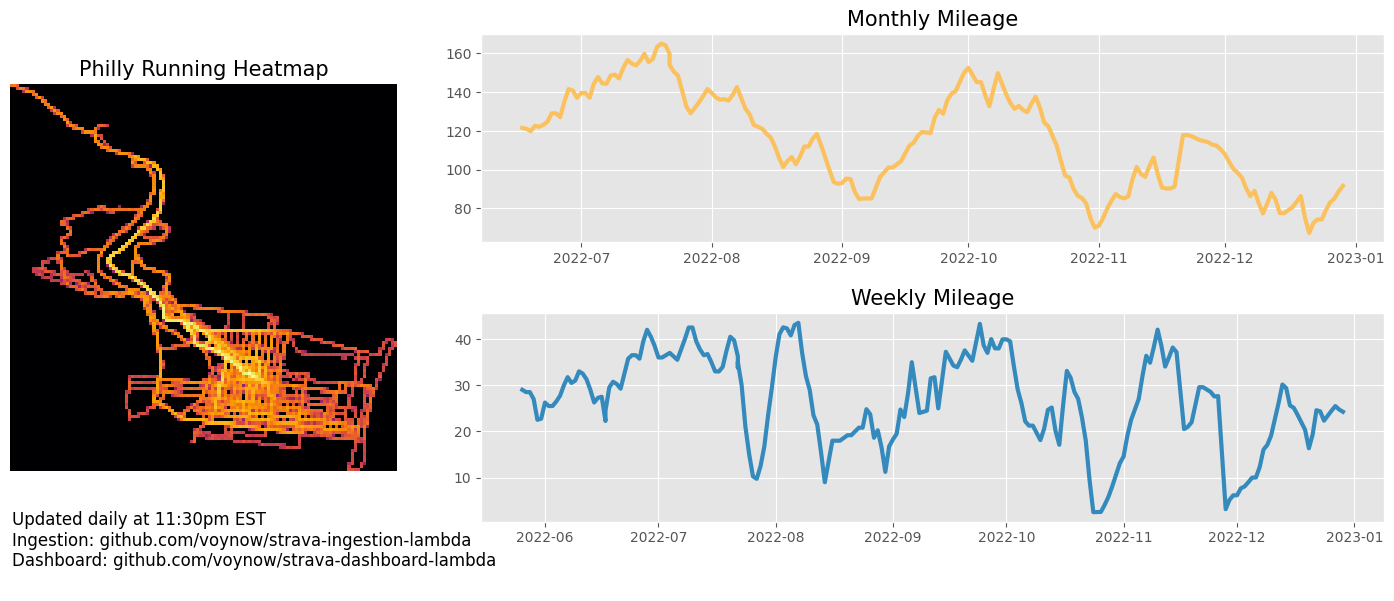

In [52]:

# Idea from: https://stackoverflow.com/questions/65265401/adding-two-smaller-subplots-to-the-side-of-my-main-plot-in-matplotlib-subplots

fig = plt.figure(constrained_layout=True, figsize=(15, 6))
footnote_text = """Updated daily at 11:30pm EST
Ingestion: github.com/voynow/strava-ingestion-lambda
Dashboard: github.com/voynow/strava-dashboard-lambda
"""

fig_configuration = [['Left', 'TopRight'],['Left', 'BottomRight']]
axs = fig.subplot_mosaic(
    fig_configuration,
    gridspec_kw={'width_ratios':[3, 7]}
)
fig.tight_layout(pad=3.0)


axs['Left'].set_title("Philly Running Heatmap", fontsize=15)
axs['Left'].imshow(img_data, cmap="inferno")
axs['Left'].tick_params(left=False, bottom=False)
axs['Left'].axis('off')

axs['TopRight'].set_title('Monthly Mileage', fontsize=15)
axs['TopRight'].plot(
        df.index, 
        df['distance_monthly_ma'], 
        c='#FBC15E', 
        linewidth=3
    )

axs['BottomRight'].set_title('Weekly Mileage', fontsize=15)
axs['BottomRight'].plot(
        df.index, 
        df['distance_week_ma'], 
        c='#348ABD', 
        linewidth=3
    )

fig.text(.05, 0, footnote_text, fontsize=12)


In [53]:
dashbaord_bucket = "strava-dashboard"
html_filename = 'index.html'
s3 = boto3.client('s3')

tmpfile = BytesIO()

fig.savefig(tmpfile, format='png')
encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
html = f'<center><img src=\'data:image/png;base64,{encoded}\'></ceneter>'

s3.put_object(
    Bucket=dashbaord_bucket,
    Key=html_filename,
    Body=html,
    ContentType="text/html",
)


{'ResponseMetadata': {'RequestId': '22QEVB32Y9CS202A',
  'HostId': 'vvn6596w1Mzeq/voSO8FimAlSKoBLI2ySgC4YBWYxEzC1hIW6rbsajkg3rPlXBsD/aOdw7dg9R4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'vvn6596w1Mzeq/voSO8FimAlSKoBLI2ySgC4YBWYxEzC1hIW6rbsajkg3rPlXBsD/aOdw7dg9R4=',
   'x-amz-request-id': '22QEVB32Y9CS202A',
   'date': 'Thu, 29 Dec 2022 23:51:36 GMT',
   'etag': '"dccc5af00a6549c445e941a126333594"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"dccc5af00a6549c445e941a126333594"'}